In [1]:
import pandas as pd

In [3]:
import os

print(os.getcwd())

/home/srcres/Coding/Learn/shuxuejianmo/2025_A题


In [4]:
DIANZHAN_ID: int = 1
TIME_COL: str = '时间'
VALUE_COL: str = '辐照强度w/m2'

In [5]:
data = pd.read_excel(f"附件/电站{DIANZHAN_ID}环境检测仪数据.xlsx", engine="openpyxl")

In [ ]:
data.dtypes

In [ ]:
print(data.head())  # 查看前几行
print(data.info())  # 检查数据类型和缺失值

In [6]:
"""
发现数据集有重复时间的，检查一下
"""

dup = data[data[TIME_COL].duplicated()]
dup

,时间,辐照强度w/m2
1589,2024-04-28 19:01:09,7.0
1591,2024-04-28 19:04:14,8.0
1593,2024-04-28 19:07:17,9.0
1908,2024-04-29 11:05:35,700.0
2397,2024-04-30 12:02:41,659.0
...,...,...
125587,2025-01-16 09:52:01,44.0
125589,2025-01-16 09:55:05,222.0
125591,2025-01-16 09:58:08,271.0
125593,2025-01-16 10:01:12,279.0


In [7]:
"""
果真发现了重复，去重，然后再检查
"""

data = data.drop_duplicates(subset=[TIME_COL], keep='first', inplace=False)

dup = data[data[TIME_COL].duplicated()]
dup # 应该是空表了（无重复数据）

,时间,辐照强度w/m2


In [9]:
"""
还发现有缺失值，去掉
"""

import numpy as np

float_cols = data.select_dtypes(include=['float'])
contains_nan_or_inf = float_cols.isna() | float_cols.applymap(np.isinf)

# 输出有内容，证明有缺失数据
print(contains_nan_or_inf[contains_nan_or_inf[VALUE_COL] == True])

/tmp/ipykernel_7579/2110891923.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  contains_nan_or_inf = float_cols.isna() | float_cols.applymap(np.isinf)


Empty DataFrame
Columns: [辐照强度w/m2]
Index: []


In [10]:
# 去掉缺失数据
data = data.dropna().copy()

# 再次检查
float_cols = data.select_dtypes(include=['float'])
contains_nan_or_inf = float_cols.isna() | float_cols.applymap(np.isinf)

# 应该没有缺失了
print(contains_nan_or_inf[contains_nan_or_inf[VALUE_COL] == True])

Empty DataFrame
Columns: [辐照强度w/m2]
Index: []


/tmp/ipykernel_7579/2268562090.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  contains_nan_or_inf = float_cols.isna() | float_cols.applymap(np.isinf)


In [11]:
"""
去重去缺后，存一份处理完的数据集
"""

data.to_csv(f"附件/电站{DIANZHAN_ID}环境检测仪数据_处理后.csv", index=False)

In [12]:
data['时间'] = pd.to_datetime(data['时间'])
data.set_index('时间', inplace=True)  # 将时间设为索引
data.head(15)

,辐照强度w/m2
时间,
2024-04-25 09:34:24,516.0
2024-04-25 09:37:27,517.0
2024-04-25 09:40:31,525.0
2024-04-25 09:43:35,526.0
2024-04-25 09:46:39,536.0
2024-04-25 09:49:43,544.0
2024-04-25 09:52:46,550.0
2024-04-25 09:55:51,551.0
2024-04-25 09:58:54,561.0


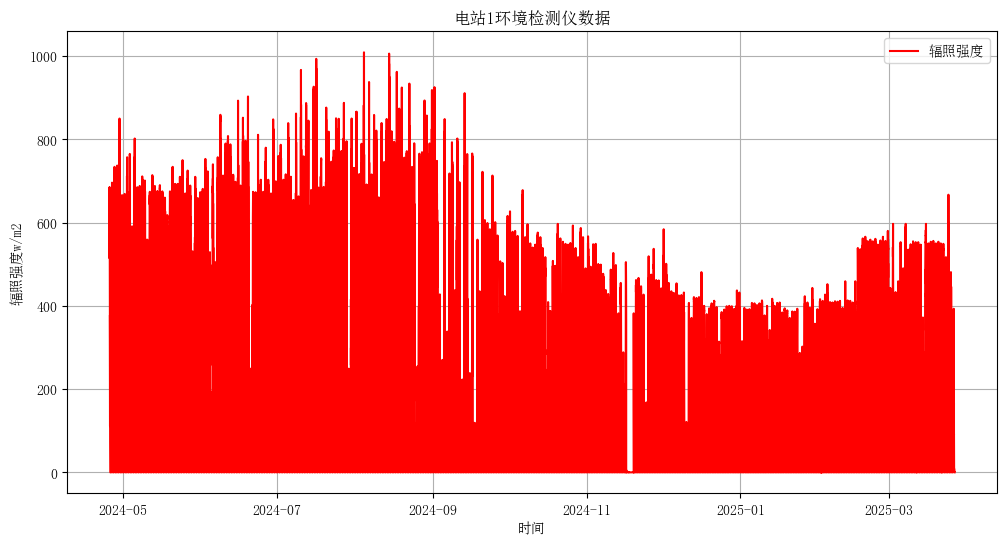

In [13]:
import matplotlib
from matplotlib import pyplot as plt

# 设置字体，能够显示中文
matplotlib.rc("font",family='SimSun',weight="bold")

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['辐照强度w/m2'], 'r-', label="辐照强度")
plt.title(f"电站{DIANZHAN_ID}环境检测仪数据")
plt.xlabel(TIME_COL)
plt.ylabel(VALUE_COL)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
data.tail(15)

In [14]:
import numpy as np
from scipy import interpolate

# 将时间转换为数值（如Unix时间戳）
timestamps = data.index.astype(np.int64) // 10**9  # 转换为秒
values = data[VALUE_COL].values

# 创建插值函数
interp_func = interpolate.interp1d(timestamps, values, kind='cubic', fill_value='extrapolate')

def get_interpolated_value(target_time):
    """
    获取任意两个离散点之间的插值
    target_time: pd.Timestamp或datetime对象
    """
    
    target_ts = pd.to_datetime(target_time).value // 10**9
    return interp_func(target_ts)

In [15]:
"""
方法1：多项式拟合
"""

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# 多项式拟合
def poly_func(x, *coefficients):
    return sum(coef * x**i for i, coef in enumerate(coefficients))

# 尝试不同阶数
degree = 3  # 可根据数据复杂度调整
p0 = [1]*(degree+1)  # 初始猜测
coeff, _ = curve_fit(poly_func, timestamps, values, p0=p0)

# 评估拟合效果
y_pred = poly_func(timestamps, *coeff)
r2 = r2_score(values, y_pred)
print(f"多项式拟合R²分数: {r2:.4f}")

多项式拟合R²分数: 0.0456


In [16]:
"""
方法2：指数平滑（更适合时间序列预测）
"""

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 创建并拟合指数平滑模型
model = ExponentialSmoothing(values, trend='add', seasonal=None, damped_trend=True)
model_fit = model.fit()

# 预测未来n个点
forecast_steps = 5
forecast = model_fit.forecast(forecast_steps)

In [17]:
"""
综合预测函数（插值+未来预测）
"""

def predict_value(target_time, method='best'):
    """
    预测任意时间点的值（包括插值和未来预测）
    target_time: pd.Timestamp或datetime对象
    method: 'interp'仅插值, 'poly'多项式, 'es'指数平滑, 'best'自动选择
    """
    target_ts = pd.to_datetime(target_time).value // 10**9
    
    # 判断是插值还是预测
    if target_time <= data.index[-1]:
        # 在已知数据范围内，使用插值
        return interp_func(target_ts)
    else:
        # 未来预测
        if method == 'best':
            # 根据拟合效果自动选择
            if r2 > 0.9:  # 如果多项式拟合效果好
                return poly_func(target_ts, *coeff)
            else:
                # 使用指数平滑
                steps_ahead = len(data[data.index > data.index[-1] - pd.Timedelta(days=1)])
                forecast = model_fit.forecast(steps_ahead)
                return forecast[-1]
        elif method == 'poly':
            return poly_func(target_ts, *coeff)
        elif method == 'es':
            steps_ahead = len(data[data.index > data.index[-1] - pd.Timedelta(days=1)])
            forecast = model_fit.forecast(steps_ahead)
            return forecast[-1]
        else:
            return interp_func(target_ts)  # 默认插值

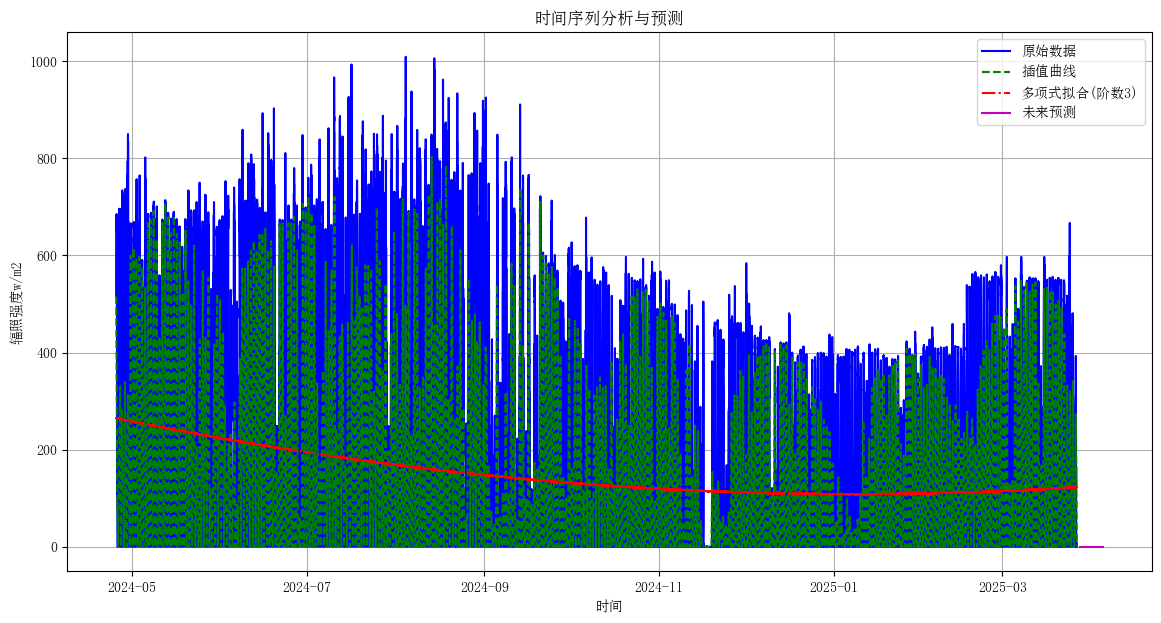

In [18]:
# 绘制拟合曲线和预测
plt.figure(figsize=(14, 7))

# 原始数据
plt.plot(data.index, values, 'b-', label='原始数据')

# 插值曲线
fine_timestamps = np.linspace(timestamps.min(), timestamps.max(), 1000)
fine_times = pd.to_datetime(fine_timestamps * 10**9)
plt.plot(fine_times, interp_func(fine_timestamps), 'g--', label='插值曲线')

# 多项式拟合
plt.plot(data.index, poly_func(timestamps, *coeff), 'r-.', label=f'多项式拟合(阶数{degree})')

# 未来预测
future_times = pd.date_range(data.index[-1], periods=10, freq='D')[1:]
future_values = [predict_value(t) for t in future_times]
plt.plot(future_times, future_values, 'm-', label='未来预测')

plt.title('时间序列分析与预测')
plt.xlabel(TIME_COL)
plt.ylabel(VALUE_COL)
plt.legend()
plt.grid(True)
plt.show()